<div style='background-image: url("./title01.png") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 200px'>
<div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
<div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Computers, Waves, Simulations</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">The Pseudo-Spectral Method - Acoustic Waves in 2D</div>
        </div>
    </div>
</div>

This notebook covers the following aspects:
* Present a  Fourier Pseudospectral code for solving the 2D acoustic wave equation
* Compute the same using using finite difference scheme

#### Exercise:
* Analyze the disperion behaviour as a function of frequency
* **Advanced**: Time the solutions for FD and PS. How much more time does PS need when the FD method looks accurate?

## Basic Equations
This notebook presents a Fourier Pseudospectral code for solving the 2D acoustic wave equation. Additionally, a solution using finite difference scheme is given for comparison.

The problem of solving the wave equation

\begin{equation}
\partial_t^2 p = c^2 (\partial_{x}^{2}p + \partial_{z}^{2}p) + s
\end{equation}

can be achieved using finite differeces in combination with spectral methods. Here, spatial partial derivatives with respect to $x$ and $z$ are computed via the Fourier method, i.e.

\begin{equation}
\partial_{x}^{2}p + \partial_{z}^{2}p = \mathscr{F}^{-1}[-k_{x}^{2}\mathscr{F}[p]] + \mathscr{F}^{-1}[-k_{z}^{2}\mathscr{F}[p]]
\end{equation}

where $\mathscr{F}$ represents the Fourier transform operator.

As it was the case in previous numerical solutions, we use a standard 3-point finite-difference operator to approximate the time derivatives. Then, the pressure field is extrapolated as

\begin{equation}
\frac{p_{j,k}^{n+1} - 2p_{j,k}^{n} + p_{j,k}^{n-1}}{dt^2}= c_{j,k}^{2} (\partial_{x}^{2}p + \partial_{z}^{2}p)_{j,k} + s_{j,k}^{n}
\end{equation}

## 0. Initialization

In [ ]:
# Block 1: Setup, Imports, and Ricker Function Fetch

# Core Libraries
import numpy as np
import matplotlib.pyplot as plt
import requests
import importlib.util
import sys
import time
from IPython import display
# Use the inline backend for manual updates
%matplotlib inline

# --- Fetch and import the Ricker wavelet function ---
url = "https://raw.githubusercontent.com/kboroz/ScientificMachineLearning/refs/heads/main/Week04%20/%20Pseudospectral%20Methods/Notebooks/ricker.py"
response = requests.get(url)

# Save temporarily
with open("ricker.py", "w") as f:
    f.write(response.text)

# Import it as a module
spec = importlib.util.spec_from_file_location("ricker", "ricker.py")
ricker_module = importlib.util.module_from_spec(spec)
sys.modules["ricker"] = ricker_module
spec.loader.exec_module(ricker_module)

ricker = ricker_module.ricker

print("Setup complete. numpy, matplotlib, IPython display, and ricker module loaded.")

Setup complete. numpy, matplotlib, IPython display, and ricker module loaded.


### 1. Fourier derivative method  

### 2. Initialization of setup

### 3. Source Initialization

In [ ]:
# Block 2: Derivative Function and Initialization

def fourier_derivative_2nd(f, dx):
    """
    Computes the second spatial derivative in 1D using the Fourier Pseudospectral method.
    This function is applied row-wise and column-wise for 2D.
    """
    nx = np.size(f)
    kmax = np.pi / dx
    dk = kmax / (nx / 2)
    k = np.arange(float(nx))

    k[: int(nx/2)] = k[: int(nx/2)] * dk
    k[int(nx/2) :] = k[: int(nx/2)] - kmax

    ff = np.fft.fft(f)
    ff = (1j*k)**2 * ff
    df_num = np.real(np.fft.ifft(ff))
    return df_num

# Basic parameters
# ---------------------------------------------------------------
nt    = 600     # number of time steps
nx    = 512     # number of grid points in x
nz    = nx      # number of grid points in z
c     = 343.    # acoustic velocity
eps   = .2      # stability limit (Courant number)
isnap = 20      # snapshot frequency (Renamed your iplot to isnap for consistency)
isx   = int(nx/2)   # source location x
isz   = int(nz/2)   # source location z
f0    = 200.    # Frequency
xmax  = 200

# Grid and time
dx = xmax / (nx - 1) # space increment
x  = np.arange(0, nx) * dx # x coordinates
z  = np.arange(0, nz) * dx # z coordinates
dt = eps * dx / c # time step

# Array Initialization - USE .copy() for independent arrays
ap = np.zeros((nx, nz), dtype=float)
apnew = ap.copy()
apold = ap.copy()
ad2px = ap.copy()
ad2pz = ap.copy()

sp = np.zeros((nx, nz), dtype=float)
spnew = sp.copy()
spold = sp.copy()
sd2px = sp.copy()
sd2pz = sp.copy()

# Source Initialization
# ---------------------------------------------------------------
t   = np.arange(1, nt + 1) * dt
T0  = 1./f0
tmp = ricker(dt, T0)
tmp = np.diff(tmp)
src = np.zeros(nt)
src[0:np.size(tmp)] = tmp

# Spatial source function (Gaussian)
sg = np.zeros((nx, nz), dtype=float)
sigma = 1.5 * dx
x0 = x[isx-1]
z0 = z[isz-1]
for i in range(nx):
    for j in range(nz):
        sg[i,j] = np.exp(-1/sigma**2 * ((x[i]-x0)**2 +(z[j]-z0)**2))
sg = sg/np.amax(sg)

print("2D Parameters, arrays, and source initialized.")

2D Parameters, arrays, and source initialized.


### 4. Time Extrapolation
The final solution for our 2D acoustic wave problem after taking into account the finite differences time extrapolation can be written as

\begin{equation}
p_{j,k}^{n+1} = dt^2c_{j,k}^{2} (\partial_{x}^{2}p + \partial_{z}^{2}p)_{j,k} + dt^2s_{j,k}^{n} + 2p_{j,k}^{n} - p_{j,k}^{n-1}
\end{equation}

In order to compare the above numerical solution, we implement a 5-point finite difference operator to compute spatial derivatives

\begin{equation}
\partial_t^2 p(x,t) = \frac{-p(x,t+2\mathrm{d}t) + 16p(x,t+\mathrm{d}t) - 30p(x,t) + 16p(x,t-\mathrm{d}t) - p(x,t-2\mathrm{d}t)}{12\mathrm{d}t^2}
\end{equation}

temporal derivative is done with a 3-point finite difference operator.

#### Numerical dispersion and anysotropy

One of the most significant characteristics of the fourier method is the low numerical dispersion in comparison with the finite difference method. The snapshots displayed below for both solutions allow us to brifly comment two significant observations:

1) There is strong anisotropic dispersion behaviour visible for the finite-difference solution. The most accurate direction occur at $\theta = \pi/4$

2) The Fourier solution do not exhibit significant dispersion, but the most importantly, it does not seem to be directionally dependent. In other words the error is isotropic.

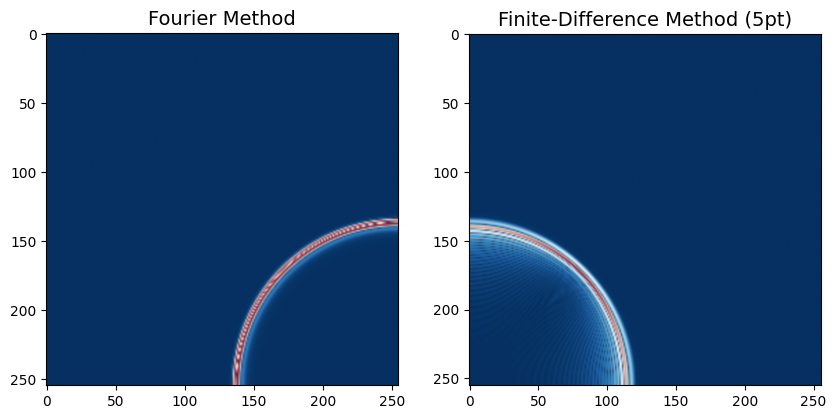

KeyboardInterrupt: 

In [ ]:
# Block 3: Time Extrapolation and Corrected Animation Loop

# --- Initialization of Plotting ---
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.set_title('Fourier Method', size=14)
ax2.set_title('Finite-Difference Method (5pt)', size=14)

# Initialize data sections
# Fourier Method: Top-Left (1:nx/2, 1:nz/2)
sp_sec_init = -np.abs(sp[1:int(nx/2), 1:int(nz/2)])
# FD Method: Bottom-Left Transposed (nx/2:nx, 1:nz/2).T
ap_sec_init = -np.abs(ap[int(nx/2):nx, 1:int(nz/2)].T)

# Set a common color scale range (Vmin/Vmax) based on initial estimates/max source amplitude
# This is crucial for a smooth animation
vmax = 5E-1
vmin = -vmax

# Store the image objects (line1, line2) - CRITICAL FIX
line1 = ax1.imshow(sp_sec_init, interpolation="bicubic", cmap=plt.cm.RdBu)
line2 = ax2.imshow(ap_sec_init, interpolation="bicubic", cmap=plt.cm.RdBu)

# Add colorbars for visual clarity
#fig.colorbar(line1, ax=ax1, fraction=0.046, pad=0.04)
#fig.colorbar(line2, ax=ax2, fraction=0.046, pad=0.04)

plt.show() # Display the initial (empty) plot

# ---------------------------------------------------------------
# Time extrapolation
# ---------------------------------------------------------------
for it in range(nt):

    # --- Fourier Pseudospectral Method ---
    # 2nd space derivative (x-direction, applied column-wise)
    for j in np.arange(nz):
        # sp[:, j].T is equivalent to sp[:, j] if sp is (nx, nz), but
        # the fourier_derivative_2nd function expects 1D input, so
        # passing the column sp[:, j] is correct for derivatives w.r.t x-direction.
        sd2px[:,j] = fourier_derivative_2nd(sp[:,j], dx)

    # 2nd space derivative (z-direction, applied row-wise)
    for i in np.arange(nx):
        sd2pz[i,:] = fourier_derivative_2nd(sp[i,:], dx)

    # Time Extrapolation
    spnew = 2*sp - spold + c**2 * dt**2 * (sd2px + sd2pz)
    spnew = spnew + sg*src[it]*dt**2 # Add sources
    spold, sp = sp, spnew # Time levels
    # Note: No explicit boundary conditions were applied in your 2D PS code.
    # The spectral method implicitly assumes periodic boundaries.

    # --- Finite Differences Method 5pt ---
    # 2nd derivatives (x-direction, applied along rows/index 0)
    for j in range(2, nz-2):
        ad2px[j,:] = (-1./12*ap[j+2,:] + 4./3*ap[j+1,:] - 5./2*ap[j,:]
                      + 4./3*ap[j-1,:] - 1./12*ap[j-2,:])/dx**2
    # 2nd derivatives (z-direction, applied along columns/index 1)
    for i in range(2, nx-2):
        ad2pz[:,i] = (-1./12*ap[:,i+2] + 4./3*ap[:,i+1] - 5./2*ap[:,i]
                      + 4./3*ap[:,i-1] - 1./12*ap[:,i-2])/dx**2

    apnew = 2*ap - apold + dt**2 * c**2 * (ad2px + ad2pz) # Time Extrapolation
    apnew = apnew + sg*src[it]*dt**2 # Add source
    apold, ap = ap, apnew # Time levels
    # Note: No explicit boundary conditions were applied in your 2D FD code.

    # --------------------------------------
    # ANIMATION UPDATE (THE 2D FIX)
    # --------------------------------------
    if not it % isnap:
        # 1. Select Sections for plotting (keep original sections)
        sp_sec = -np.abs(sp[1:int(nx/2), 1:int(nz/2)])
        ap_sec = -np.abs(ap[int(nx/2):nx, 1:int(nz/2)].T)

        # 2. Update the image data using set_data() - CRITICAL FIX
        line1.set_data(sp_sec)
        line2.set_data(ap_sec)

        # 3. Force Colab to clear and redraw the figure
        display.clear_output(wait=True)
        display.display(fig)

        # 4. Pause briefly to control animation speed
        time.sleep(0.01)

# Final display of the figure after the loop completes
display.clear_output(wait=True)
display.display(fig)
print("2D Simulation finished. Final plot displayed.")